In [1]:
import pandas as pd
from transformers import AutoTokenizer,AutoModelForSequenceClassification,pipeline
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import RobertaTokenizer, RobertaModel,BertTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns
from ktrain import text


In [2]:
df = pd.read_csv("/Users/Tequliali/Documents/GU-ANLY580-PROJECT-master/cleaned_data/droppedDF.csv")
df = df.drop(columns=['Unnamed: 0'])
df['selftext'] = df['selftext'].astype('str') 
df

,domain,title,selftext
0,explainlikeimfive,ELI5: What exactly is Obamacare and what did i...,I understand what medicare is and everything b...
1,explainlikeimfive,ELI5 has defaulted!,We were informed yesterday by the reddit admin...
2,explainlikeimfive,The Five-Year-Old's Guide to the Galaxy,Below is a hand-picked collection of outstandi...
3,explainlikeimfive,ELI67 Please explain like I'm 67 the differenc...,"I know this kind of breaks the rules, but I th..."
4,explainlikeimfive,"[META] Okay, this sub is slowly turning into /...",Questions here are supposed to be covering com...
...,...,...,...
4353,IAmA,"I am Christine Ha, MasterChef Season 3 Winner....",I am Christine Ha. I have an autoimmune condi...
4354,IAmA,"Reddit w/ Gov. Gary Johnson, Honorary Chairman...","WHO AM I? I am Gov. Gary Johnson, Honorary Cha..."
4355,IAmA,AMA Request - The White House staffer/Redditor...,- What is your position? \n- How far up the c...
4356,IAmA,IAmA quadriplegic who games without the use of...,I broke my neck 5 years ago falling 18ft from ...


In [3]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.is_fast

True

In [4]:
batch_size = 1000
def batch_iterator():
    for i in range(0, len(df), batch_size):
        yield df[i : i + batch_size]["selftext"]
new_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(), vocab_size=25000)

In [5]:
tokenizer = Tokenizer(models.WordPiece(unl_token="[UNK]"))
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)
tokenizer.train_from_iterator(batch_iterator(), trainer=trainer)

In [6]:
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")
print(cls_token_id, sep_token_id)

2 3


In [7]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", cls_token_id),
        ("[SEP]", sep_token_id),
    ],
)

In [8]:
new_tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

In [9]:
o = new_tokenizer(df['selftext'].tolist())['input_ids']
bert_token = pd.DataFrame(o)
df['domain'].replace({"explainlikeimfive": 0, "Showerthoughts": 1, "worldnews": 2,
                              "funny": 3, "pics": 4, "woahdude": 5,
                              "food": 6, "Jokes": 7, "AskReddit": 8,
                              "LifeProTips": 9, "books": 10, "todayilearned": 11,
                              "GetMotivated": 12, "movies": 13, "IAmA": 14}, inplace=True)
df

,domain,title,selftext
0,0.0,ELI5: What exactly is Obamacare and what did i...,I understand what medicare is and everything b...
1,0.0,ELI5 has defaulted!,We were informed yesterday by the reddit admin...
2,0.0,The Five-Year-Old's Guide to the Galaxy,Below is a hand-picked collection of outstandi...
3,0.0,ELI67 Please explain like I'm 67 the differenc...,"I know this kind of breaks the rules, but I th..."
4,0.0,"[META] Okay, this sub is slowly turning into /...",Questions here are supposed to be covering com...
...,...,...,...
4353,14.0,"I am Christine Ha, MasterChef Season 3 Winner....",I am Christine Ha. I have an autoimmune condi...
4354,14.0,"Reddit w/ Gov. Gary Johnson, Honorary Chairman...","WHO AM I? I am Gov. Gary Johnson, Honorary Cha..."
4355,14.0,AMA Request - The White House staffer/Redditor...,- What is your position? \n- How far up the c...
4356,14.0,IAmA quadriplegic who games without the use of...,I broke my neck 5 years ago falling 18ft from ...


In [10]:
# load bert tokens
X = bert_token
Y = np.nan_to_num(df['domain'])

In [11]:
seed = 7
test_size = 0.10
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

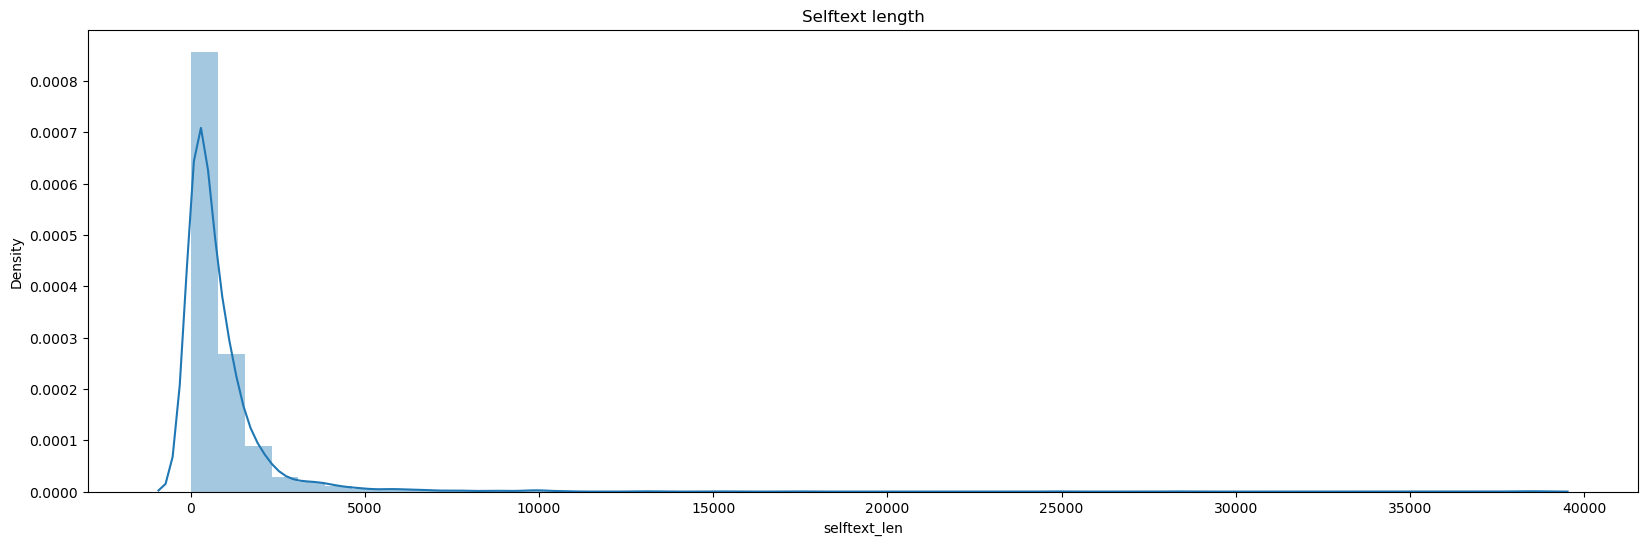

In [12]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
df['selftext_len'] = df['selftext'].apply(lambda x : len(x))
df['selftext_wordCnt'] = df['selftext'].apply(lambda x : len(x.split(' ')))
df['selftext_tokenCnt'] = df['selftext'].apply(lambda x : len(tokenizer.encode(x, add_special_tokens=False)))
df
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(df['selftext_len'], ax=ax).set_title('Selftext length')
plt.show()

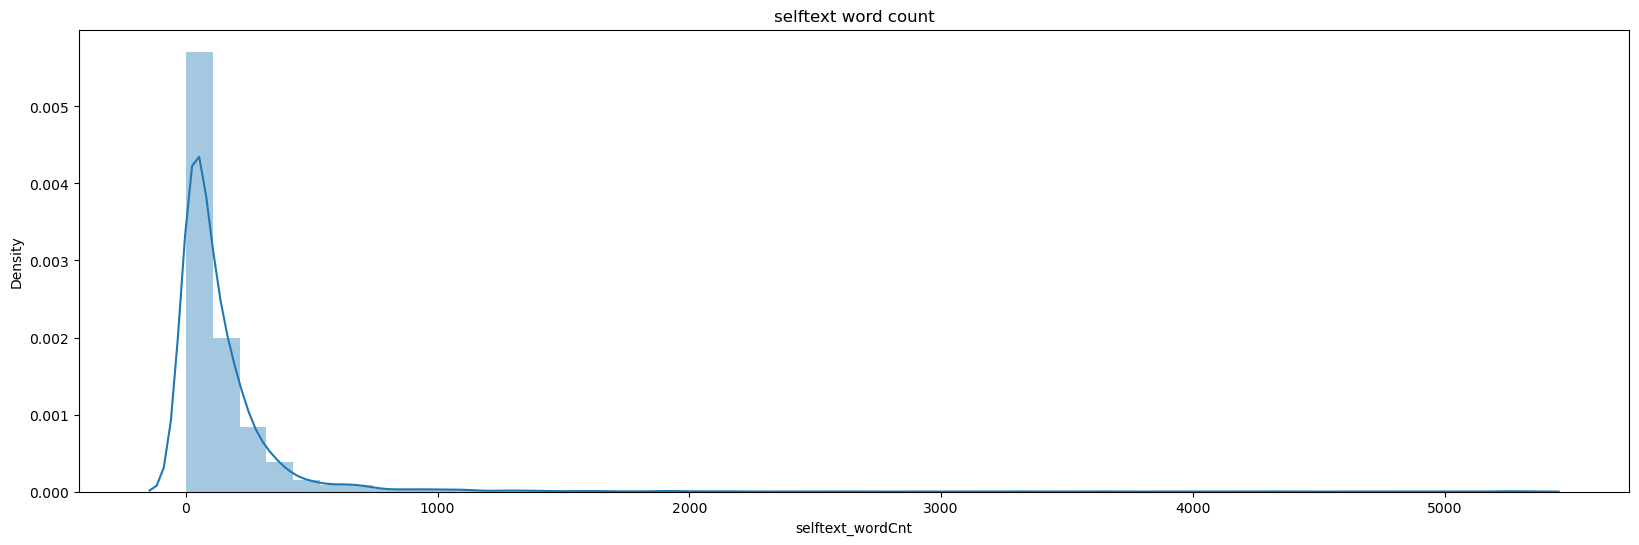

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.distplot(df['selftext_wordCnt'], ax=ax).set_title('selftext word count')
plt.show()

In [31]:
import datasets
from datasets import load_dataset
M = 8000
df_train= datasets.load_dataset('csv', data_files="/Users/Tequliali/Documents/GU-ANLY580-PROJECT-master/cleaned_data/droppedDF.csv",split= 'train')
df_train = df_train.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.8 * M)]
df_test= datasets.load_dataset('csv', data_files="/Users/Tequliali/Documents/GU-ANLY580-PROJECT-master/cleaned_data/droppedDF.csv",split= 'train')
df_test = df_test.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.2 * M)]
#dataset['selftext']

Using custom data configuration default-4e7263173234936c
Reusing dataset csv (/Users/tequliali/.cache/huggingface/datasets/csv/default-4e7263173234936c/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)
Using custom data configuration default-4e7263173234936c
Reusing dataset csv (/Users/tequliali/.cache/huggingface/datasets/csv/default-4e7263173234936c/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


In [33]:
df_train['domain'].replace({"explainlikeimfive": 0, "Showerthoughts": 1, "worldnews": 2,
                              "funny": 3, "pics": 4, "woahdude": 5,
                              "food": 6, "Jokes": 7, "AskReddit": 8,
                              "LifeProTips": 9, "books": 10, "todayilearned": 11,
                              "GetMotivated": 12, "movies": 13, "IAmA": 14}, inplace=True)
df_train['selftext'] = df_train['selftext'].astype('str') 
X_train = []
for i in df_train['selftext']:
    X_train.append(i)
#X_train = [df_train['selftext']]
y_train = np.nan_to_num(df_train['domain'])

In [34]:
print(X_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [35]:
#from transformers import RobertaTokenizer, RobertaModel
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#model = RobertaModel.from_pretrained('roberta-base')
#encoded_input = tokenizer(dataset['selftext'], return_tensors='pt')
#output = model(**encoded_input)
len(X_train), len(X_test)
Model_name = 'distilbert-base-uncased'
trans = text.Transformer(Model_name, maxlen = 512, class_names = y_train)

In [36]:
train_data = trans.preprocess_train(X_train,y_train)

preprocessing train...
language: en
train sequence lengths:
	mean : 144
	95percentile : 450
	99percentile : 1086


Is Multi-Label? False


In [37]:
import sys
sys.setrecursionlimit(8000)
model = trans.get_classifier()

RecursionError: maximum recursion depth exceeded in comparison